In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from data_providers.price_history_sliding_window_data_provider \
    import PriceHistorySlidingWindowDataProvider
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
#from models.price_history_rnn_full_len import PriceHistoryRnnFullLen

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [5]:
from common import get_or_run_nn

# Baseline is static, a straight line for each input

In [6]:
#csv_in = '../price_history_03a_fixed_width.csv'
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [7]:
arr = np.load(npz_path)

In [8]:
arr.keys()

['inputs', 'sequence_masks', 'targets', 'sequence_lengths']

In [9]:
inputs = arr['inputs']
inputs.shape

(11374, 60, 1)

In [10]:
targets = arr['targets']
targets.shape

(11374, 30)

In [11]:
target_len = targets.shape[1]
target_len

30

In [12]:
preds = np.empty(shape=targets.shape + (1,))
preds.shape

(11374, 30, 1)

In [13]:
for ii, cur_in in enumerate(inputs):
    #print cur_in.shape
    #print cur_in[-1].shape
    preds[ii] = cur_in[-1]  #broadcasting
    #print np.repeat(cur_in[-1], target_len).shape
    #print np.repeat(cur_in[-1:], target_len)
    #print dummy_targets[ii].shape
    #print dummy_targets[ii]

### evaluate

In [14]:
# dyn_stats, preds_dict = get_or_run_nn(experiment,
#                                       filename='002_rnn_gru_60to30')
# epochs: 10
# End Epoch 01 (43.118 secs): err(train) = 7.8218
# End Epoch 02 (41.229 secs): err(train) = 6.9381
# End Epoch 03 (41.370 secs): err(train) = 6.4451
# End Epoch 04 (41.662 secs): err(train) = 6.0338
# End Epoch 05 (41.484 secs): err(train) = 5.4984
# End Epoch 06 (41.337 secs): err(train) = 5.0515
# End Epoch 07 (41.292 secs): err(train) = 4.6289
# End Epoch 08 (43.233 secs): err(train) = 4.2015
# End Epoch 09 (43.128 secs): err(train) = 3.7842
# End Epoch 10 (41.224 secs): err(train) = 3.4302

In [15]:
data_len = len(inputs)
assert len(preds) == len(targets) and data_len == len(targets)

In [16]:
mses = np.empty(data_len)

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    mses[ii] = mean_squared_error(pred, target)

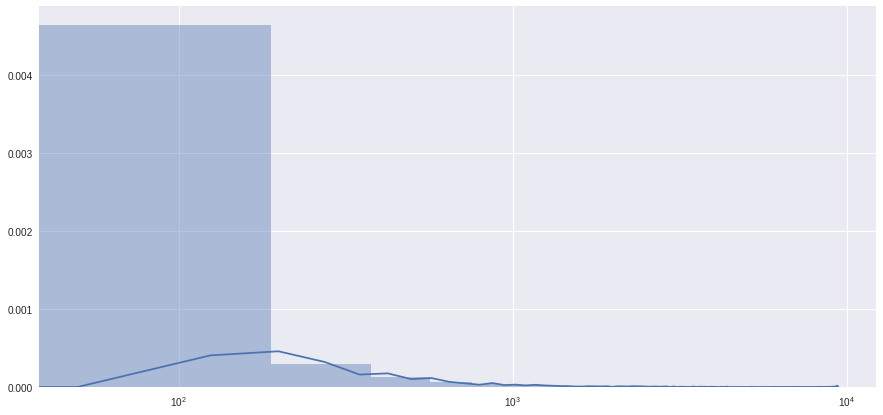

In [19]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(mses, ax=ax)
plt.show()

#### MSE loss

In [20]:
np.mean(mses)

120.24097972070805

#### Huber Loss

In [21]:
def huber_loss(y_true, y_pred):
    err = y_true - y_pred
    
    absolute = np.abs(err)
    
    ifthen = 0.5 * err
    ifelse = absolute - 0.5
    
    return np.where(absolute < 1.0, ifthen, ifelse)

In [22]:
huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    huber_losses[ii] = np.mean(huber_loss(pred, target))

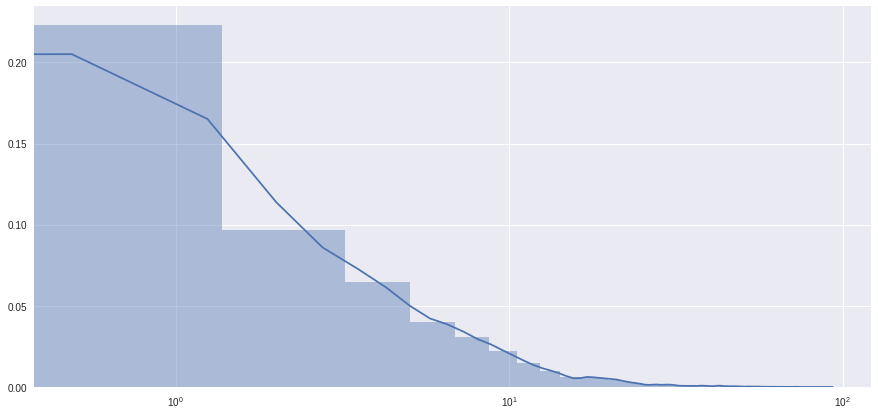

In [23]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(huber_losses, ax=ax)
plt.show()

In [24]:
np.mean(huber_losses)

4.7877014975675518

In [25]:
targets.shape

(11374, 30)

In [26]:
%%time
dtw_scores = [fastdtw(targets[ind], preds[ind])[0]
              for ind in range(len(targets))]

CPU times: user 1min 13s, sys: 232 ms, total: 1min 13s
Wall time: 1min 13s


In [27]:
np.mean(dtw_scores)

153.9703173905398

### plots

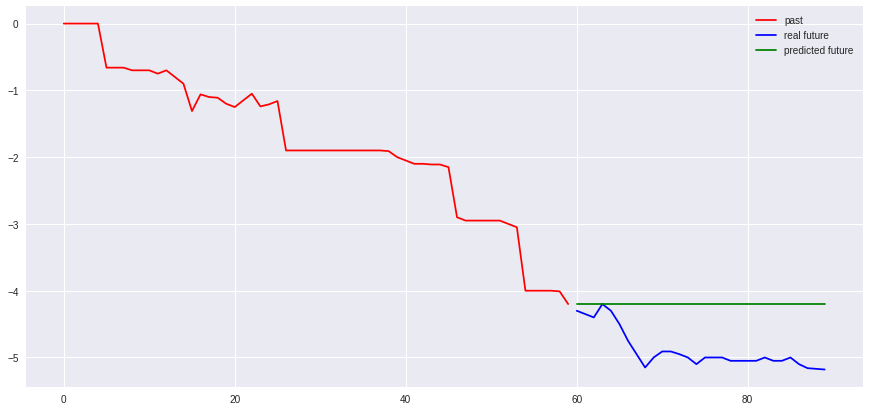

In [53]:
ind = np.random.randint(len(inputs))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()

### Conclusion
Huber loss of more than 4.7 is a really bad performance for our regression model

# Baseline is the trend, a static slope

In [29]:
XX = np.arange(60).reshape(-1, 1)
XX.shape

(60, 1)

In [30]:
XX_pred = np.arange(60, 90).reshape(-1, 1)
XX_pred.shape

(30, 1)

In [31]:
lr_preds = np.empty(shape=targets.shape + (1,))
lr_preds.shape

(11374, 30, 1)

In [32]:
%%time
for ii, cur_in in enumerate(inputs):
    lr_preds[ii] = LinearRegression().fit(XX, y=cur_in.flatten()).predict(
        XX_pred).reshape(-1, 1)

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.06 s


In [33]:
# testin = inputs[ind].flatten()
# testtar = targets[ind].flatten()
# yy = inputs[ind].flatten()
# yy.shape
# lr = LinearRegression(fit_intercept=False).fit(XX, yy)
# lr.coef_
# lr.intercept_
# testpred = lr.predict(np.arange(60, 90).reshape(-1, 1))
# testpred.shape

#### plots

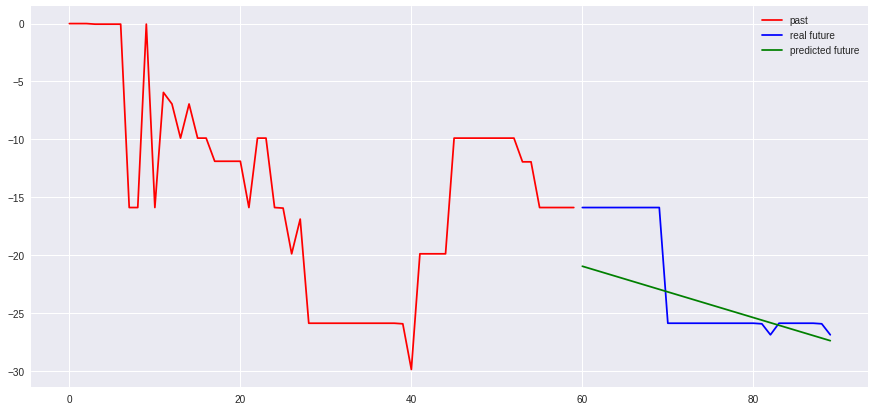

In [47]:
ind = np.random.randint(len(inputs))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), lr_preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()

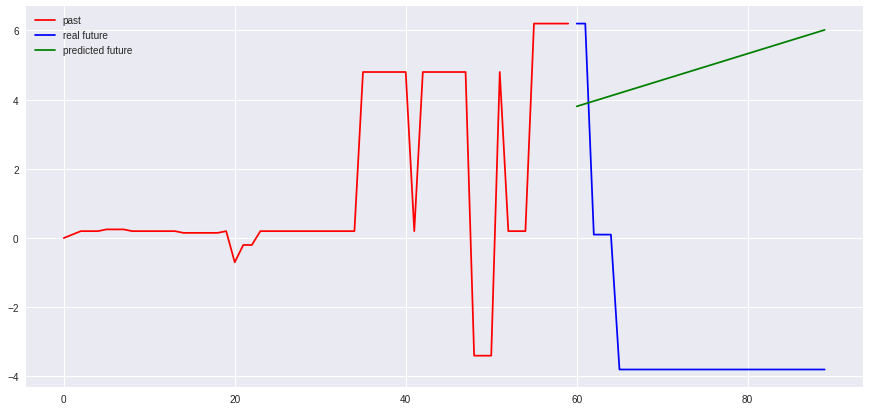

In [50]:
ind = np.random.randint(len(inputs))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), lr_preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()

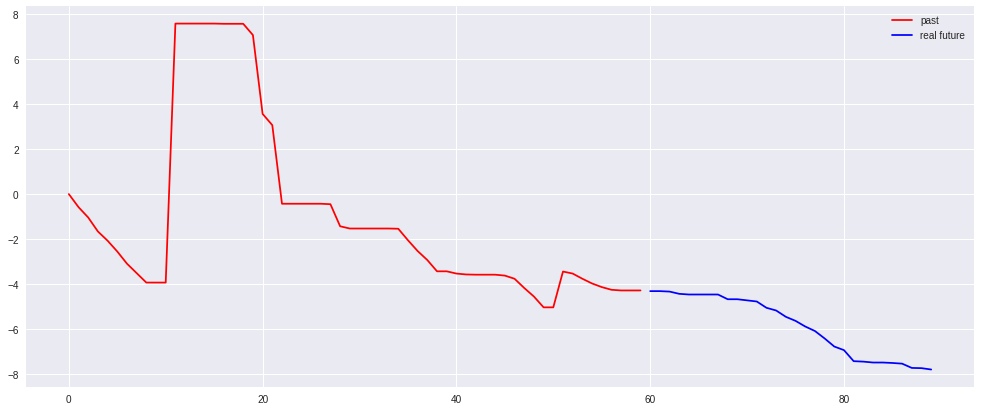

In [49]:
ind = np.random.randint(len(inputs))
fig = plt.figure(figsize=(17,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r', label='past')
plt.plot(range(60, 90), targets[ind].flatten(), 'b', label='real future')
plt.legend()
plt.show()

## evaluate

In [35]:
lr_mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(lr_preds, targets)):
    lr_mses[ii] = mean_squared_error(pred, target)

In [36]:
np.mean(lr_mses)

266.09965436560969

In [37]:
lr_huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(lr_preds, targets)):
    lr_huber_losses[ii] = np.mean(huber_loss(pred, target))

In [38]:
np.mean(lr_huber_losses)

8.2460293404062863

In [39]:
%%time
dtw_scores = [fastdtw(targets[ind], lr_preds[ind])[0]
              for ind in range(len(targets))]

CPU times: user 1min 14s, sys: 212 ms, total: 1min 14s
Wall time: 1min 14s


In [40]:
np.mean(dtw_scores)

249.84022790118669

# Is detrending the same as removing the linear regression line?

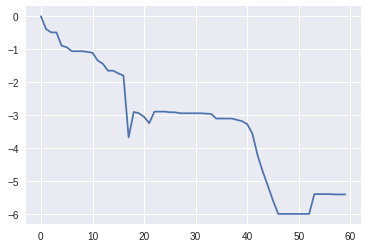

In [41]:
ss = inputs[ind].flatten()
plt.plot(ss)

In [42]:
line = LinearRegression().fit(XX, y=ss).predict(XX)
line.shape

(60,)

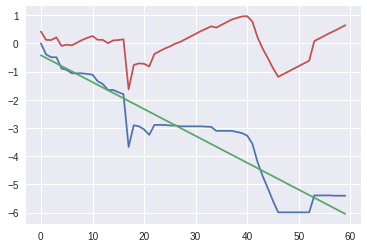

In [43]:
plt.plot(ss)
plt.plot(line)
plt.plot(ss-line)
plt.show()

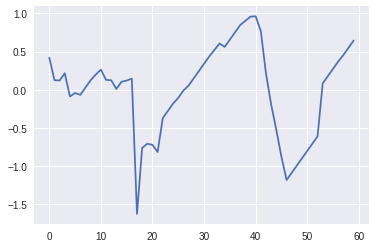

In [44]:
plt.plot(detrend(ss))

In [45]:
np.allclose(detrend(ss), ss - line)

True

Answer to above question: YES